---
title: "How WEIRD is ICWSM?"
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['figure.dpi'] = 150

In [3]:
plt.rcParams['font.family'] = ['Linux Libertine O']

# Loading Data & Metrics

In [4]:
df = pd.concat([
    pd.read_csv('datasets/icwsm-full-normalized-v2.csv').assign(paper_type='full'),
    pd.read_csv('datasets/icwsm-rest-normalized-v2.csv').assign(paper_type='rest'),
], ignore_index=True)

In [5]:
df['paper_id'].nunique()

420

In [369]:
cip = pd.read_csv('datasets/cip.csv', encoding_errors='ignore')
democratic = pd.read_csv('datasets/democratic.csv')
edu = pd.read_csv('datasets/edu.csv')
gdp = pd.read_csv('datasets/gdp.csv')
gni = pd.read_csv('datasets/gni.csv')
western = pd.read_csv('datasets/western.csv')
population = pd.read_csv('datasets/population.csv').query('Time == 2020')
internet = pd.read_csv('datasets/internet.csv')

/var/folders/0d/380dd3_d27v3p6p6m6nb230h0000gn/T/ipykernel_89504/2025423398.py:7: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  population = pd.read_csv('datasets/population.csv').query('Time == 2020')


In [372]:
cip['countrydesc'] = (
    cip.countrydesc
    .replace("Cte d'Ivoire", "Côte d'Ivoire")
    .replace("China, Taiwan Province", "China, Taiwan Province of China")
    .replace("Lao People's Dem Rep", "Lao People's Democratic Republic")
    .replace("Turkey", "Türkiye")
)

In [373]:
cip_gdp = cip[['countrydesc', 'cip', 'year']].query('year == 2020').merge(
    (
        gdp[['Country Name', 'Country Code', '2020']]
        .replace('Korea, Rep.', 'Republic of Korea')
        .replace('United States', 'United States of America')
        .replace('Turkiye', 'Turkey')
        .replace('Viet Nam', 'Vietnam')
        .replace('Iran, Islamic Rep.', 'Iran (Islamic Republic of)')
        .replace('Egypt, Arab Rep.', 'Egypt')
    ),
    how='left',
    left_on='countrydesc',
    right_on='Country Name'
)

In [374]:
TOTAL_POPULATION = population[population['ISO3_code'].notna()]['PopTotal'].sum()

# Preliminary Analysis

In [335]:
data = df.copy()

In [336]:
print(f"Number of analyzed papers: {data['paper_id'].nunique()}")

Number of analyzed papers: 420


In [383]:
indust = cip.query('year == 2020')[['countrydesc','cip']].assign(cip=cip.query('year == 2020')['cip'].apply(np.log).replace(-np.inf, np.nan))
indust.merge(
    internet[['Country Name', '2020']],
    how='inner',
    left_on='countrydesc',
    right_on='Country Name'
).dropna()[['cip', '2020']].corr()

,cip,2020
cip,1.000000,0.711921
2020,0.711921,1.000000


In [337]:
def combine(df):
    return (
        pd.merge(
            df,
            population.dropna(subset='ISO3_code')[['ISO3_code', 'Location', 'PopTotal']],
            how='left',
            left_on='country_code',
            right_on='ISO3_code',
        )
        .rename({'country_code': 'country'}, axis=1)
        .merge(
            cip.query('year == 2020')[['countrydesc','cip']].assign(cip=cip.query('year == 2020')['cip'].apply(np.log).replace(-np.inf, np.nan)),
            how='left',
            left_on='Location',
            right_on='countrydesc',
        )
        .merge(
            gdp.assign(country=gdp['Country Code'], gdp=gdp['2020'])[['country', 'gdp']],
            how='left',
            on='country',
        )
        .merge(
            gni.assign(country=gni['Country Code'], gni=gni['2020'])[['country', 'gni']],
            how='left',
            on='country',
        )
        .merge(
            western,
            how='left',
            on='country',
        )
        .merge(
            edu,
            how='left',
            left_on='Location',
            right_on='country_name',
        )
        .merge(
            democratic,
            how='left',
            left_on='Location',
            right_on='country_name',
        )
    )

def get_stats(data, is_icwsm=True):
    if is_icwsm:
        stats = data.groupby('country_code').agg({
            'nb_records': 'sum',
        }).rename({'nb_records': 'nb_papers'}, axis=1)
    else:
        stats = data.groupby('country_code').agg({
            'nb_participants': 'sum',
            'paper_id': pd.Series.nunique
        }).rename({'paper_id': 'nb_papers'}, axis=1)

    # stats['participants_pct'] = stats['nb_participants'] / stats['nb_participants'].sum()
    stats['papers_pct'] = stats['nb_papers'] / stats['nb_papers'].sum()

    stats = combine(stats.reset_index())
    stats['population_pct'] = stats['PopTotal'] / TOTAL_POPULATION
    # stats['psi_p'] = stats['participants_pct'] / stats['population_pct']
    stats['psi_s'] = stats['papers_pct'] / stats['population_pct']

    stats['var_e'] = stats['mean_edu']
    stats['var_i'] = stats['cip']
    stats['var_r'] = stats['gni']
    stats['var_d'] = stats['political rights']

    stats['educated'] = stats['var_e'].gt(stats['var_e'].median())
    stats['industrialized'] = stats['var_i'].gt(stats['var_i'].median())
    stats['rich'] = stats['var_r'].gt(stats['var_r'].median())
    stats['democratic'] = stats['var_d'].gt(stats['var_d'].median())
    return stats

In [338]:
# Getting base table for the analysis, contains info for Table 2
stats = get_stats(data)

In [339]:
assert stats[stats['west'].isnull()].empty

In [340]:
print(
    stats
    .sort_values('psi_s', ascending=False)
    .filter(['Location', 'nb_papers', 'papers_pct', 'psi_s'])
    .head(10)
    .set_index('Location')
    .style.format({
        'nb_papers': '{:,.2f}',
        'papers_pct': '{:.2%}',
        'psi_s': '{:.2f}'
    })
    .to_latex()
)

\begin{tabular}{lrrr}
 & nb_papers & papers_pct & psi_s \\
Location &  &  &  \\
Dominica & 0.20 & 0.05% & 53.96 \\
Malta & 1.00 & 0.25% & 37.69 \\
United States of America & 182.66 & 45.25% & 10.56 \\
French Guiana & 0.12 & 0.03% & 8.34 \\
Singapore & 2.31 & 0.57% & 7.59 \\
Qatar & 1.03 & 0.26% & 7.27 \\
Barbados & 0.09 & 0.02% & 6.37 \\
United Kingdom & 18.65 & 4.62% & 5.40 \\
Norway & 1.44 & 0.36% & 5.21 \\
Israel & 2.15 & 0.53% & 4.77 \\
\end{tabular}



In [341]:
print(
    stats
    .sort_values('papers_pct', ascending=False)
    .filter(['Location', 'nb_papers', 'papers_pct', 'psi_s'])
    .head(10)
    .set_index('Location')
    .style.format({
        'nb_papers': '{:,.2f}',
        'papers_pct': '{:.2%}',
        'psi_s': '{:.2f}'
    })
    .to_latex()
)

\begin{tabular}{lrrr}
 & nb_papers & papers_pct & psi_s \\
Location &  &  &  \\
United States of America & 182.66 & 45.25% & 10.56 \\
India & 25.92 & 6.42% & 0.36 \\
Japan & 21.77 & 5.39% & 3.38 \\
United Kingdom & 18.65 & 4.62% & 5.40 \\
Brazil & 13.64 & 3.38% & 1.24 \\
China & 12.69 & 3.14% & 0.17 \\
Germany & 9.82 & 2.43% & 2.29 \\
Indonesia & 9.19 & 2.28% & 0.66 \\
France & 8.14 & 2.02% & 2.45 \\
Italy & 7.18 & 1.78% & 2.35 \\
\end{tabular}



## Drawing Teaser Figure

In [342]:
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

/var/folders/0d/380dd3_d27v3p6p6m6nb230h0000gn/T/ipykernel_89504/1534872835.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


In [343]:
plt.rcParams['font.size'] = 8

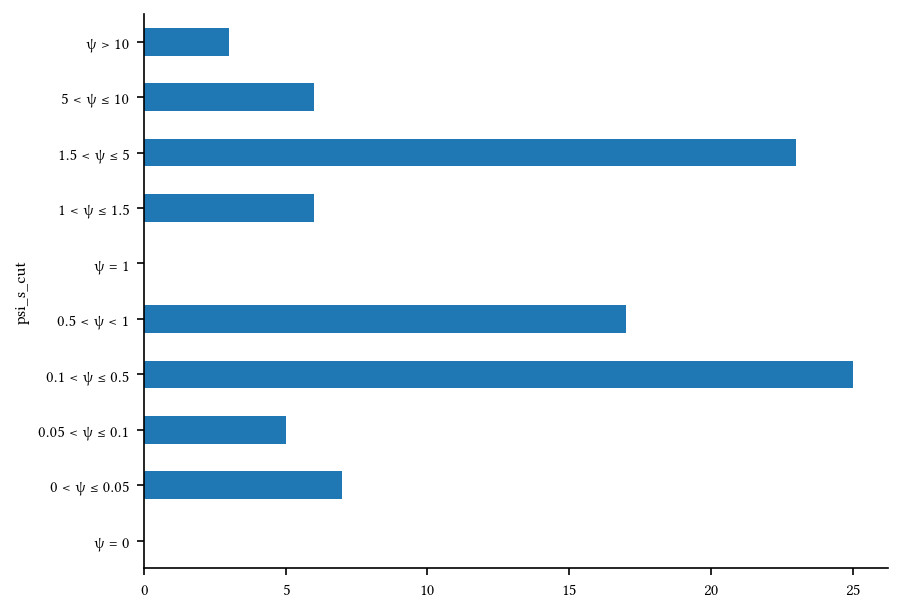

In [344]:
stats['psi_s_cut'] = pd.cut(
    stats['psi_s'],
    [-np.inf, 0, 0.05, 0.1, 0.5, 0.9999, 1.0001, 1.5, 5, 10, np.inf],
    labels=['ψ = 0', '0 < ψ ≤ 0.05', '0.05 < ψ ≤ 0.1', '0.1 < ψ ≤ 0.5', '0.5 < ψ < 1', 'ψ = 1', '1 < ψ ≤ 1.5', '1.5 < ψ ≤ 5', '5 < ψ ≤ 10', 'ψ > 10']
)
stats['psi_s_cut'].value_counts().sort_index().plot.barh();

In [345]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['#efefef'] + ['#d73027','#fc8d59','#fee090','#fff4bd','#ffffff','#e0f3f8','#acdae8','#91bfdb','#4575b4'][::-1])

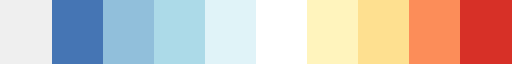

In [346]:
cmap

For the following map, $\psi > 1.5$ means over-represented, $\psi < 0.5$ means under-represented

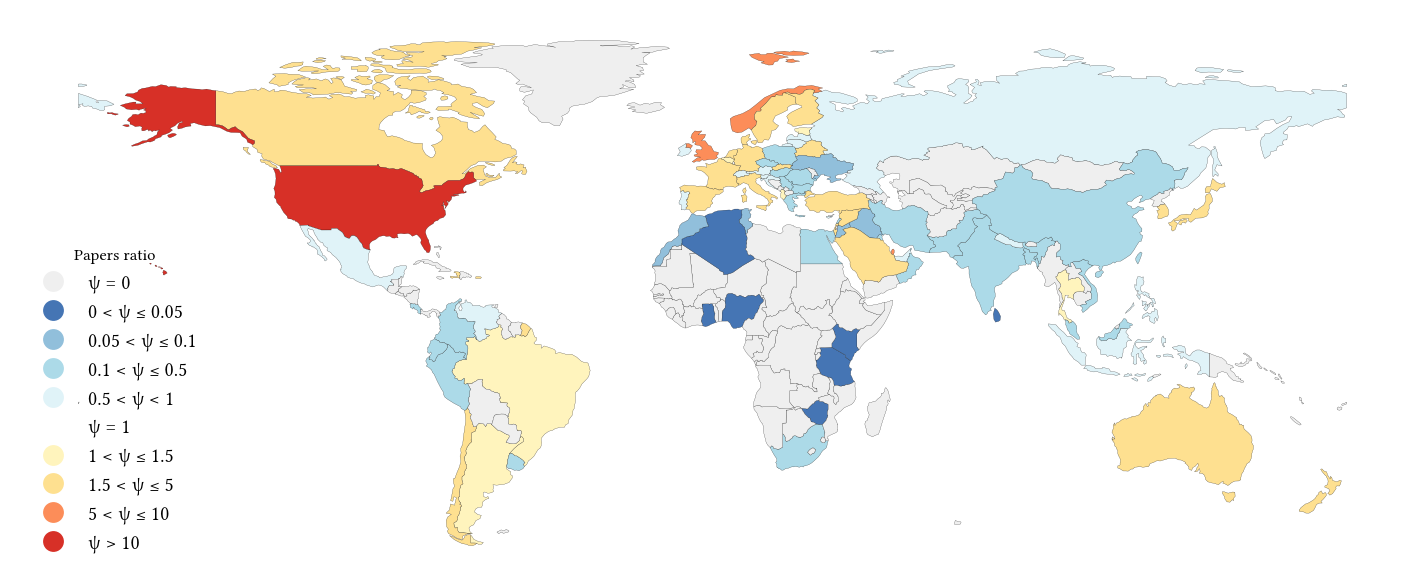

In [347]:
ax = world.query('continent != "Antarctica"').merge(
    stats,
    how='left',
    left_on='iso_a3',
    right_on='country'
).fillna('ψ = 0').plot(
    column='psi_s_cut', edgecolor='black',
    linewidth=0.1, figsize=(12, 7),
    legend=True,
    legend_kwds=dict(
        title='Papers ratio',
        loc='lower left',
        frameon=False,
        fontsize=9.5,
    ),
    cmap=cmap
)
plt.axis('off')
plt.savefig('figures/world-map.pdf', dpi=150, bbox_inches='tight')

# RQ1: How WEIRD is the ICWSM conference?

In [434]:
from scipy.stats import kendalltau, permutation_test

def compute_metric(stats, x1, x2, bootstrap=False, is_print=True):
    variables = stats[[x1, x2]].dropna()
    if bootstrap:
        tau = [kendalltau(*variables.sample(len(variables), replace=True).values.T)[0] for _ in range(10_000)]
        mu = np.array(tau).mean()
        sigma = 2 * np.array(tau).std()

        if is_print:
            print(f"{mu:.2f};[{mu - sigma:.2f}, {mu + sigma:.2f}]")
        else:
            return np.array(tau)

        # def statistic(x):
        #     return kendalltau(x, variables[x2]).statistic

        # ref = permutation_test((variables[x1],), statistic, n_resamples=10_000, permutation_type='pairings')
        # tau = ref.statistic
        # lb, ub = np.quantile(ref.null_distribution, [0.025, 0.975])

        # if is_print:
        #     print(f"{tau:.2f};[{lb:.2f}, {ub:.2f}]")
        # else:
        #     return ref.null_distribution
    else:
        tau, p_value = kendalltau(*variables.values.T)
        if is_print:
            print(f"tau = {tau:.2f}, p-val = {p_value:.4f}")
        else:
            return tau, p_value

In [435]:
# This is a sandbox to see how Kendall tau rank correlation works.
# Try to change the value of a and b and see what happens to the correlation.
from scipy.stats import spearmanr, kendalltau

z = pd.DataFrame({
    "country": ["USA", "GBR", "DEU", "JPN"],
    "a": [4, 3, 1, 2],
    "b": [4, 3, 2, 1]
})
print(z)
print(kendalltau(z['a'], z['b']))
print(spearmanr(z['a'], z['b']))

  country  a  b
0     USA  4  4
1     GBR  3  3
2     DEU  1  2
3     JPN  2  1
SignificanceResult(statistic=0.6666666666666669, pvalue=0.3333333333333333)
SignificanceResult(statistic=0.7999999999999999, pvalue=0.20000000000000007)


In [436]:
unique_papers = data.groupby('paper_id').size()
unique_paper_ids = unique_papers[unique_papers.eq(1)].index.to_list()

In [437]:
# Exclusively studying USA
data[data['paper_id'].isin(unique_paper_ids)].country_code.eq('USA').sum() / data['paper_id'].nunique()

0.26666666666666666

In [438]:
# Western
# 1 = Exclusively Western
# 0 = Exclusively non-Western
# [0, 1] = Mixed
w_score = combine(data).groupby('paper_id').west.mean().value_counts(False).reset_index()
w_score['var'] = np.select(
    [w_score['west'] == 1, w_score['west'] == 0],
    ['Exclusively Western', 'Exclusively non-Western'],
    'Mixed'
)
w_score = w_score.groupby('var').agg({'count': 'sum'})
w_score.assign(percentage=w_score['count'] / w_score['count'].sum()).style.format({'percentage': '{:.2%}'})

,count,percentage
var,,
Exclusively Western,157,37.38%
Exclusively non-Western,51,12.14%
Mixed,212,50.48%


In [439]:
# Computing EIRD
compute_metric(stats, 'var_e', 'psi_s', bootstrap=False)
compute_metric(stats, 'var_i', 'psi_s', bootstrap=False)
compute_metric(stats, 'var_r', 'psi_s', bootstrap=False)
compute_metric(stats, 'var_d', 'psi_s', bootstrap=False)

tau = 0.36, p-val = 0.0000
tau = 0.35, p-val = 0.0000
tau = 0.49, p-val = 0.0000
tau = 0.32, p-val = 0.0000


In [440]:
np.random.seed(42)

# Computing EIRD
compute_metric(stats, 'var_e', 'psi_s', bootstrap=True)
compute_metric(stats, 'var_i', 'psi_s', bootstrap=True)
compute_metric(stats, 'var_r', 'psi_s', bootstrap=True)
compute_metric(stats, 'var_d', 'psi_s', bootstrap=True)

0.36;[0.23, 0.49]
0.35;[0.20, 0.50]
0.49;[0.36, 0.61]
0.33;[0.20, 0.45]


## FAccT

In [359]:
facct = pd.read_csv('datasets/weird_faccts.csv')
facct['paper_id'] = facct['paper_id'].ffill()
facct['publication_year'] = facct['publication_year'].ffill()
facct['non_human'] = facct['non_human'].notna()
facct['synthetic'] = facct['synthetic'].notna()
facct = facct.drop(['paper_title', 'url', 'url_data', 'notes'], axis=1)
facct = facct.replace('y', True).replace('n', False)

facct = facct.query('~non_human and ~synthetic and nb_records.notna() and country.notna()').copy()
facct['nb_participants'] = facct['nb_records'].astype('float')
facct['original'] = facct['original'].fillna(False)

facct_data = facct[['paper_id', 'country', 'nb_participants']].rename({'country': 'country_code'}, axis=1)
facct_stats = get_stats(facct_data, is_icwsm=False)

In [360]:
(
    facct_stats
    .sort_values('papers_pct', ascending=False)
    .filter(['Location', 'nb_papers', 'papers_pct', 'psi_s'])
    .head(10)
    .set_index('Location')
    .style.format({
        'nb_papers': '{:,.0f}',
        'papers_pct': '{:.2%}',
        'psi_s': '{:.2f}'
    })
)

,nb_papers,papers_pct,psi_s
Location,,,
United States of America,106,46.49%,10.85
Germany,20,8.77%,8.25
United Kingdom,12,5.26%,6.15
India,8,3.51%,0.20
Portugal,7,3.07%,23.38
"China, Taiwan Province of China",4,1.75%,5.77
Canada,4,1.75%,3.63
Sweden,4,1.75%,13.27
Ireland,4,1.75%,27.81


In [361]:
# Western
# 1 = Exclusively Western
# 0 = Exclusively non-Western
# [0, 1] = Mixed
w_score = combine(facct_data).groupby('paper_id').west.mean().value_counts(False).reset_index()
w_score['var'] = np.select(
    [w_score['west'] == 1, w_score['west'] == 0],
    ['Exclusively Western', 'Exclusively non-Western'],
    'Mixed'
)
w_score = w_score.groupby('var').agg({'count': 'sum'})
w_score.assign(percentage=w_score['count'] / w_score['count'].sum()).style.format({'percentage': '{:.2%}'})

,count,percentage
var,,
Exclusively Western,108,84.38%
Exclusively non-Western,9,7.03%
Mixed,11,8.59%


In [362]:
# Computing EIRD
compute_metric(facct_stats, 'var_e', 'psi_s', bootstrap=False)
compute_metric(facct_stats, 'var_i', 'psi_s', bootstrap=False)
compute_metric(facct_stats, 'var_r', 'psi_s', bootstrap=False)
compute_metric(facct_stats, 'var_d', 'psi_s', bootstrap=False)

tau = 0.31, p-val = 0.0016
tau = 0.01, p-val = 0.9010
tau = 0.34, p-val = 0.0005
tau = 0.37, p-val = 0.0002


In [363]:
# Computing EIRD
compute_metric(facct_stats, 'var_e', 'psi_s', bootstrap=True)
compute_metric(facct_stats, 'var_i', 'psi_s', bootstrap=True)
compute_metric(facct_stats, 'var_r', 'psi_s', bootstrap=True)
compute_metric(facct_stats, 'var_d', 'psi_s', bootstrap=True)

0.31;[0.12, 0.50]
0.01;[-0.21, 0.23]
0.34;[0.20, 0.49]
0.37;[0.20, 0.55]


## CHI

In [364]:
chi_data = pd.read_csv('datasets/chi_psi_s.csv').rename({'country': 'country_code'}, axis=1)
chi_stats = combine(chi_data)
chi_stats['var_e'] = chi_stats['mean_edu']
chi_stats['var_i'] = chi_stats['cip']
chi_stats['var_r'] = chi_stats['gni']
chi_stats['var_d'] = chi_stats['political rights']

In [365]:
# Computing EIRD
compute_metric(chi_stats, 'var_e', 'psi_s', bootstrap=False)
compute_metric(chi_stats, 'var_i', 'psi_s', bootstrap=False)
compute_metric(chi_stats, 'var_r', 'psi_s', bootstrap=False)
compute_metric(chi_stats, 'var_d', 'psi_s', bootstrap=False)

tau = 0.43, p-val = 0.0000
tau = 0.27, p-val = 0.0002
tau = 0.50, p-val = 0.0000
tau = 0.51, p-val = 0.0000


In [366]:
# Computing EIRD
compute_metric(chi_stats, 'var_e', 'psi_s', bootstrap=True)
compute_metric(chi_stats, 'var_i', 'psi_s', bootstrap=True)
compute_metric(chi_stats, 'var_r', 'psi_s', bootstrap=True)
compute_metric(chi_stats, 'var_d', 'psi_s', bootstrap=True)

0.43;[0.30, 0.57]
0.27;[0.13, 0.41]
0.49;[0.37, 0.62]
0.51;[0.41, 0.61]


# RQ2: Dataset & Posters vs Full

In [384]:
df_full = pd.read_csv('datasets/icwsm-full-normalized-v2.csv').assign(paper_type='full')
df_rest = pd.read_csv('datasets/icwsm-rest-normalized-v2.csv').assign(paper_type='rest')

In [385]:
df_full['paper_id'].nunique()

302

In [386]:
df_rest['paper_id'].nunique()

118

In [387]:
# Western
# 1 = Exclusively Western
# 0 = Exclusively non-Western
# [0, 1] = Mixed
w_score = combine(df_full).groupby('paper_id').west.mean().value_counts(False).reset_index()
w_score['var'] = np.select(
    [w_score['west'] == 1, w_score['west'] == 0],
    ['Exclusively Western', 'Exclusively non-Western'],
    'Mixed'
)
w_score = w_score.groupby('var').agg({'count': 'sum'})
w_score.assign(percentage=w_score['count'] / w_score['count'].sum()).style.format({'percentage': '{:.2%}'})

,count,percentage
var,,
Exclusively Western,121,40.07%
Exclusively non-Western,33,10.93%
Mixed,148,49.01%


In [388]:
# Western
# 1 = Exclusively Western
# 0 = Exclusively non-Western
# [0, 1] = Mixed
w_score = combine(df_rest).groupby('paper_id').west.mean().value_counts(False).reset_index()
w_score['var'] = np.select(
    [w_score['west'] == 1, w_score['west'] == 0],
    ['Exclusively Western', 'Exclusively non-Western'],
    'Mixed'
)
w_score = w_score.groupby('var').agg({'count': 'sum'})
w_score.assign(percentage=w_score['count'] / w_score['count'].sum()).style.format({'percentage': '{:.2%}'})

,count,percentage
var,,
Exclusively Western,36,30.51%
Exclusively non-Western,18,15.25%
Mixed,64,54.24%


In [389]:
from scipy.stats import chi2_contingency

contingency = [
    [121, 33, 148],
    [36, 18, 64],
]

chi2_contingency(contingency)

Chi2ContingencyResult(statistic=3.8416946560814633, pvalue=0.14648279055482874, dof=2, expected_freq=array([[112.89047619,  36.67142857, 152.43809524],
       [ 44.10952381,  14.32857143,  59.56190476]]))

In [390]:
np.random.seed(42)

compute_metric(get_stats(df_full), 'var_e', 'psi_s', bootstrap=True)
compute_metric(get_stats(df_full), 'var_i', 'psi_s', bootstrap=True)
compute_metric(get_stats(df_full), 'var_r', 'psi_s', bootstrap=True)
compute_metric(get_stats(df_full), 'var_d', 'psi_s', bootstrap=True)

0.40;[0.27, 0.52]
0.39;[0.24, 0.53]
0.48;[0.35, 0.61]
0.39;[0.27, 0.51]


In [391]:
np.random.seed(42)

compute_metric(get_stats(df_rest), 'var_e', 'psi_s', bootstrap=True)
compute_metric(get_stats(df_rest), 'var_i', 'psi_s', bootstrap=True)
compute_metric(get_stats(df_rest), 'var_r', 'psi_s', bootstrap=True)
compute_metric(get_stats(df_rest), 'var_d', 'psi_s', bootstrap=True)

0.28;[0.14, 0.41]
0.30;[0.15, 0.46]
0.41;[0.28, 0.54]
0.21;[0.06, 0.36]


In [392]:
assert df.shape[0] == df_full.shape[0] + df_rest.shape[0]

In [393]:
full_ids = df_full['paper_id'].unique().tolist()
nb_full = len(full_ids)

In [394]:
from tqdm import trange

np.random.seed(42)

for col in [
    'var_e',
    'var_i',
    'var_r',
    'var_d',
]:
    tau_diff = []
    for _ in trange(1000):
        full_paper_ids = np.random.choice(data['paper_id'].unique(), nb_full, replace=False)

        tau_full = compute_metric(get_stats(data.query('paper_id in @full_paper_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
        tau_rest = compute_metric(get_stats(data.query('paper_id not in @full_paper_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
        tau_diff.append(tau_full - tau_rest)

    tau_full = compute_metric(get_stats(data.query('paper_id in @full_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
    tau_rest = compute_metric(get_stats(data.query('paper_id not in @full_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]

    delta_tau = tau_full - tau_rest
    tau_diff = np.array(tau_diff)
    pval = (tau_diff > delta_tau).mean()
    print(f"{col}, {delta_tau:.2f}, [{np.quantile(tau_diff, 0.025):.2f}, {np.quantile(tau_diff, 0.975):.2f}], pval={pval:.4f}")

100%|██████████| 1000/1000 [00:17<00:00, 55.73it/s]


var_e, 0.12, [-0.12, 0.11], pval=0.0190


100%|██████████| 1000/1000 [00:17<00:00, 56.26it/s]


var_i, 0.08, [-0.15, 0.09], pval=0.0450


100%|██████████| 1000/1000 [00:18<00:00, 53.91it/s]


var_r, 0.07, [-0.14, 0.16], pval=0.1790


100%|██████████| 1000/1000 [00:18<00:00, 54.60it/s]


var_d, 0.18, [-0.14, 0.12], pval=0.0010


In [395]:
less_democratic_papers = combine(df_rest).groupby('paper_id').agg({
    'country': list,
    'political rights': 'mean'
})
less_democratic_papers = less_democratic_papers[less_democratic_papers['political rights'].lt(democratic['political rights'].median())]

In [396]:
less_democratic_papers

,country,political rights
paper_id,,
https://ojs.aaai.org/index.php/ICWSM/article/view/15064/14914,[CHN],-2.000000
https://ojs.aaai.org/index.php/ICWSM/article/view/15071/14921,[SGP],19.000000
https://ojs.aaai.org/index.php/ICWSM/article/view/19375/19147,"[IRN, BGD, RUS, VEN, ARE]",6.000000
https://ojs.aaai.org/index.php/ICWSM/article/view/19378/19150,[BLR],2.000000
https://ojs.aaai.org/index.php/ICWSM/article/view/19382/19154,"[IND, PAK, RUS, BRA, COL]",22.800000
https://ojs.aaai.org/index.php/ICWSM/article/view/19384/19156,[QAT],7.000000
https://ojs.aaai.org/index.php/ICWSM/article/view/19385/19157,"[VEN, CHL]",19.500000
https://ojs.aaai.org/index.php/ICWSM/article/view/19401/19173,"[CHN, USA, DEU]",23.333333
https://ojs.aaai.org/index.php/ICWSM/article/view/7349/7203,[SYR],-3.000000


# RQ3: Cross-country Authorships

In [397]:
authors = pd.read_parquet('datasets/author-western.parquet')
authors['url'] = authors['url'].str.replace('download', 'view')

In [398]:
papers_weird = combine(data).groupby('paper_id').agg({
    'west': 'mean',
    'mean_edu': 'mean',
    'cip': 'mean',
    'gni': 'mean',
    'political rights': 'mean'
}).reset_index()

In [399]:
paper_author = papers_weird.merge(authors, how='left', left_on='paper_id', right_on='url')
paper_author[['mean_edu', 'cip', 'gni', 'political rights', 'nb_countries']].corr()

,mean_edu,cip,gni,political rights,nb_countries
mean_edu,1.000000,0.687446,0.911021,0.613497,-0.104439
cip,0.687446,1.000000,0.716124,0.279801,-0.035514
gni,0.911021,0.716124,1.000000,0.451217,-0.059806
political rights,0.613497,0.279801,0.451217,1.000000,-0.162021
nb_countries,-0.104439,-0.035514,-0.059806,-0.162021,1.000000


In [400]:
paper_author.loc[paper_author['paper_id'].eq('https://ojs.aaai.org/index.php/ICWSM/article/view/19360/19132'), 'nb_countries'] = 1
paper_author.loc[paper_author['paper_id'].eq('https://ojs.aaai.org/index.php/ICWSM/article/view/19360/19132'), 'western'] = 'Exclusively Western'
paper_author.loc[paper_author['paper_id'].eq('https://ojs.aaai.org/index.php/ICWSM/article/view/19360/19132'), 'nb_authors'] = 2

In [401]:
paper_author.loc[paper_author['paper_id'].eq('https://ojs.aaai.org/index.php/ICWSM/article/view/3247/3115'), 'nb_countries'] = 1
paper_author.loc[paper_author['paper_id'].eq('https://ojs.aaai.org/index.php/ICWSM/article/view/3247/3115'), 'western'] = 'Exclusively non-Western'
paper_author.loc[paper_author['paper_id'].eq('https://ojs.aaai.org/index.php/ICWSM/article/view/3247/3115'), 'nb_authors'] = 1

In [402]:
print(f"Mean nb authors = {paper_author['nb_authors'].mean():.1f}")
print(f"Std dev nb authors = {paper_author['nb_authors'].std():.1f}")

Mean nb authors = 4.0
Std dev nb authors = 2.0


In [403]:
paper_author['country_code'].explode().nunique()

43

In [404]:
iso_codes = pd.read_csv('datasets/iso_codes.tsv', sep='\\t')

/var/folders/0d/380dd3_d27v3p6p6m6nb230h0000gn/T/ipykernel_89504/2131706901.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  iso_codes = pd.read_csv('datasets/iso_codes.tsv', sep='\\t')


In [405]:
# TODO Check nan

In [406]:
pd.merge(
    iso_codes[iso_codes['iso_code_2'].isin(paper_author['country_code'].explode().unique())].dropna(),
    western,
    how='left',
    left_on='iso_code_3',
    right_on='country'
)['west'].sum()

23

In [407]:
paper_author['nb_countries'].eq(1).mean()

0.7214285714285714

In [408]:
# paper_id = paper_author[paper_author['political rights'].isnull()].paper_id.iloc[0]
# data[data['paper_id'].eq(paper_id)]
# combine(data).query('paper_id == @paper_id')

In [409]:
from scipy.stats import pearsonr

pa = paper_author.dropna()
for var in ['mean_edu', 'cip', 'gni', 'political rights']:
    res = pearsonr(pa[var], pa['nb_countries'])
    ci = res.confidence_interval(confidence_level=0.95)
    print(f"{res[0]:.2f} & [{ci[0]:.2f}, {ci[1]:.2f}] {res[1]:.3f}")

-0.11 & [-0.20, -0.01] 0.028
-0.03 & [-0.12, 0.07] 0.565
-0.06 & [-0.16, 0.04] 0.224
-0.16 & [-0.26, -0.07] 0.001


In [410]:
paper_ids = paper_author['paper_id'].unique().tolist()
multiple_country_ids = paper_author[paper_author['nb_countries'].gt(1)].paper_id.to_list()
nb_multiple_countries = paper_author[paper_author['nb_countries'].gt(1)].shape[0]

In [412]:
np.random.seed(42)

for col in [
    'mean_edu',
    'cip',
    'gni',
    'political rights'
]:
    tau_diff = []
    for _ in range(1000):
        multiple_ids = np.random.choice(paper_ids, nb_multiple_countries)

        tau_multiple = compute_metric(get_stats(data.query('paper_id in @multiple_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
        tau_single = compute_metric(get_stats(data.query('paper_id not in @multiple_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
        tau_diff.append(tau_single - tau_multiple)

    tau_multiple = compute_metric(get_stats(data.query('paper_id in @multiple_country_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]
    tau_single = compute_metric(get_stats(data.query('paper_id not in @multiple_country_ids')), col, 'psi_s', bootstrap=False, is_print=False)[0]

    delta_tau = tau_single - tau_multiple
    tau_diff = np.array(tau_diff)
    pval = (tau_diff >= delta_tau).mean()
    print(f"{col}, {delta_tau:.2f}, [{np.quantile(tau_diff, 0.025):.2f}, {np.quantile(tau_diff, 0.975):.2f}], pval={pval:.4f}")

mean_edu, -0.01, [-0.14, 0.12], pval=0.4910
cip, 0.10, [-0.15, 0.09], pval=0.0210
gni, 0.06, [-0.14, 0.14], pval=0.2300
political rights, -0.02, [-0.14, 0.11], pval=0.4810


In [144]:
def map_western(value):
    if value == 0:
        return "Exclusively non-Western"
    elif value == 1:
        return "Exclusively Western"
    else:
        return "Mixed"

In [145]:
paper_author['west_paper'] = paper_author['west'].apply(map_western)

In [146]:
from scipy.stats import chi2_contingency

contingency = paper_author.pivot_table(
    index='western',
    columns='west_paper',
    values='nb_authors',
    aggfunc='count'
)

print(chi2_contingency(contingency))

print(
    contingency.divide(contingency.sum(axis=1), axis=0)
    .style.format('{:.1%}')
    .to_latex()
)

Chi2ContingencyResult(statistic=23.862317118289628, pvalue=8.511402175606147e-05, dof=4, expected_freq=array([[122.60952381,  39.82857143, 165.56190476],
       [ 16.07380952,   5.22142857,  21.7047619 ],
       [ 18.31666667,   5.95      ,  24.73333333]]))
\begin{tabular}{lrrr}
west_paper & Exclusively Western & Exclusively non-Western & Mixed \\
western &  &  &  \\
Exclusively Western & 41.8% & 8.8% & 49.4% \\
Exclusively non-Western & 25.6% & 27.9% & 46.5% \\
Mixed & 18.4% & 20.4% & 61.2% \\
\end{tabular}



In [60]:
less_democratic = paper_author[paper_author['nb_countries'].gt(2) & paper_author['political rights'].lt(democratic['political rights'].median())]
less_democratic['paper_id'].to_list()

['https://ojs.aaai.org/index.php/ICWSM/article/view/15064/14914',
 'https://ojs.aaai.org/index.php/ICWSM/article/view/15071/14921',
 'https://ojs.aaai.org/index.php/ICWSM/article/view/18053/17856',
 'https://ojs.aaai.org/index.php/ICWSM/article/view/18079/17882',
 'https://ojs.aaai.org/index.php/ICWSM/article/view/19277/19049',
 'https://ojs.aaai.org/index.php/ICWSM/article/view/19348/19120',
 'https://ojs.aaai.org/index.php/ICWSM/article/view/7281/7135']

In [61]:
paper_author.loc[371, 'paper_id']

'https://ojs.aaai.org/index.php/ICWSM/article/view/7313/7167'